In [ ]:
# !pip install SMOTE

In [ ]:
# !pip install imbalanced-learn

In [ ]:
# !pip install -U scikit-learn imbalanced-learn

In [ ]:
#pip install tensorflow


In [ ]:
#pip install keras


In [ ]:
# pip install "tensorflow<2.11" --user

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, Activation,SpatialDropout1D
from keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.random import set_seed
import numpy as np

In [2]:
set_seed(42)

In [3]:
from functions import *

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [5]:
train.describe()

,overall
count,370863.000000
mean,4.566600
std,0.930377
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


In [6]:
train.head(20)

,overall,Review
0,5,I love these glitter pens. They sparkle deligh...
1,5,It works well with my machine. I use mostly c...
2,5,"This is a great assortment of colors, though t..."
3,5,Just what I was looking for.
4,5,I make 400 birds for the hospital each month.
5,1,not very sharp
6,5,Its just a replacement blade
7,5,"Great value,"
8,3,It is just okay for me. The plastic is a bit ...
9,5,Always happy when I find a great priced art gi...


In [7]:
train.isnull().sum()

overall    0
Review     8
dtype: int64

In [8]:
# train = train.dropna()

In [9]:
train.isnull().sum()

overall    0
Review     8
dtype: int64

In [10]:
train.duplicated().sum()

93449

In [11]:
train = train.drop_duplicates()

In [12]:
train.shape

(277414, 2)

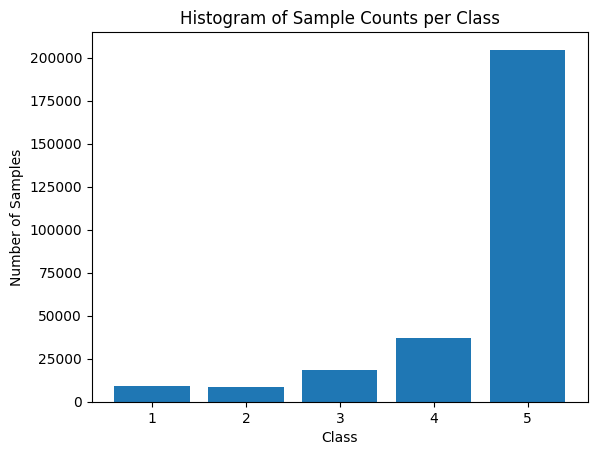

In [13]:
class_counts = train['overall'].value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Histogram of Sample Counts per Class')
plt.show()

In [14]:
test.describe()

,id
count,123622.000000
mean,61810.500000
std,35686.741826
min,0.000000
25%,30905.250000
50%,61810.500000
75%,92715.750000
max,123621.000000


In [15]:
test.head(20)

,id,Review
0,0,Wonderful asst. of wood carving tools
1,1,Pretty lace with 4 way stretch. I was exactly ...
2,2,This is a quick and easy way to start a crazy ...
3,3,"This is my favorite journals, the pages are ve..."
4,4,I bought this for a costume i was making. i wa...
5,5,Great idea but they don't cut well
6,6,Love this thread.
7,7,GOOD REUSABLE PRODUCT. MADE BAR LOTION WITH T...
8,8,After trial and error with various brands of a...
9,9,They are really smelly - like a vinyl shower c...


In [16]:
test.isnull().sum()

id        0
Review    4
dtype: int64

In [17]:
test.duplicated().sum()

0

In [18]:
test.shape

(123622, 2)

In [19]:
train["Review"]= train["Review"].astype(str)


In [20]:
tokenizer = Tokenizer(num_words = 20000)
tokenizer.fit_on_texts(train["Review"].tolist())


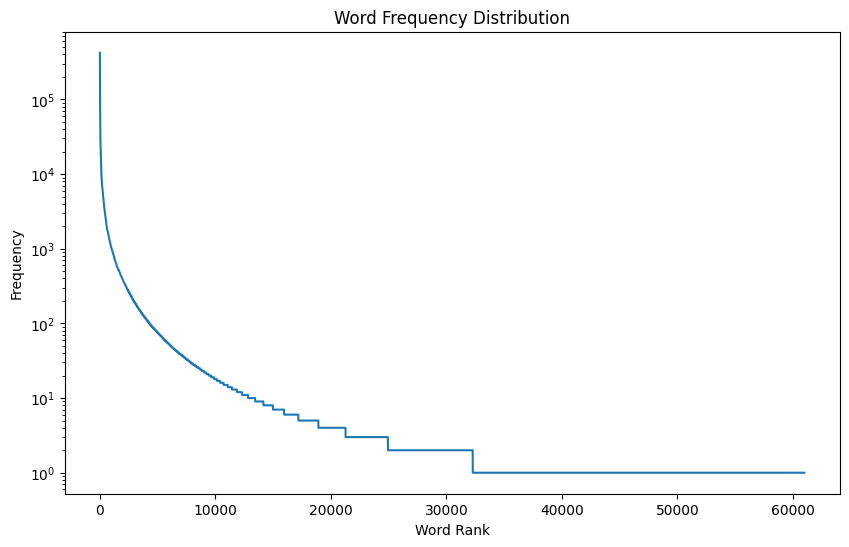

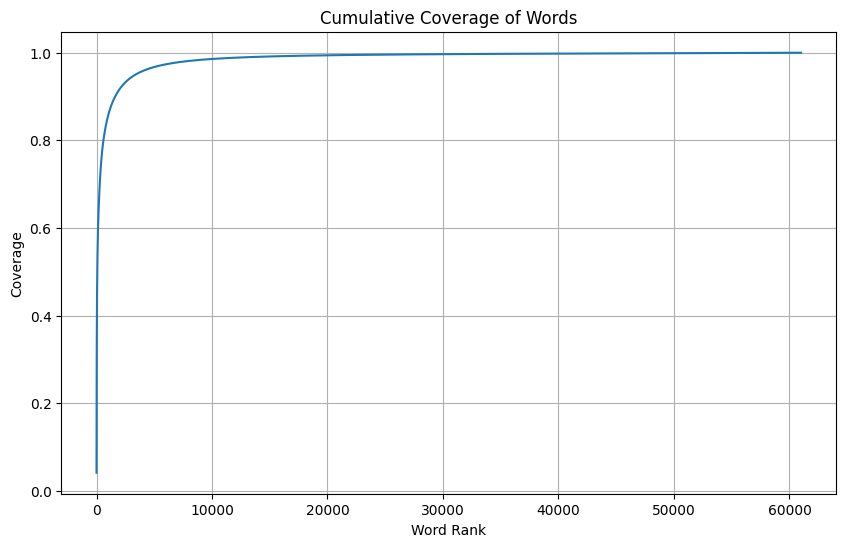

In [21]:
word_counts = tokenizer.word_counts
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot([count for _, count in sorted_word_counts])
plt.title("Word Frequency Distribution")
plt.xlabel("Word Rank")
plt.ylabel("Frequency")
plt.yscale("log")  # Use logarithmic scale to better visualize the distribution
plt.show()

# You can also plot a cumulative distribution to better understand coverage
cumulative_coverage = np.cumsum([count for _, count in sorted_word_counts]) / sum(word_counts.values())
plt.figure(figsize=(10, 6))
plt.plot(cumulative_coverage)
plt.title("Cumulative Coverage of Words")
plt.xlabel("Word Rank")
plt.ylabel("Coverage")
plt.grid(True)
plt.show()

In [22]:
sequence_lengths = [len(seq) for seq in tokenizer.texts_to_sequences(train["Review"].tolist())]
max_length = np.percentile(sequence_lengths, 95)  # Adjust the percentile as needed


In [23]:
# Convert the preprocessed reviews to sequences and pad them
train["Padded_Sequences"] = train["Review"].apply(lambda x: preprocessSequential(x, tokenizer, int(max_length)))


In [24]:
X = np.array(train["Padded_Sequences"].tolist())

In [25]:
train

,overall,Review,Padded_Sequences
0,5,I love these glitter pens. They sparkle deligh...,"[2, 31, 21, 493, 251, 23, 1204, 10120, 16, 1, ..."
1,5,It works well with my machine. I use mostly c...,"[6, 72, 38, 12, 11, 77, 2, 26, 902, 2591, 16, ..."
2,5,"This is a great assortment of colors, though t...","[9, 10, 5, 22, 650, 8, 58, 226, 94, 14, 5, 107..."
3,5,Just what I was looking for.,"[34, 51, 2, 29, 170, 7, 0, 0, 0, 0, 0, 0, 0, 0..."
4,5,I make 400 birds for the hospital each month.,"[2, 62, 2561, 7, 1, 5532, 216, 1201, 0, 0, 0, ..."
...,...,...,...
370856,5,These are the perfect application bottles for ...,"[21, 14, 1, 75, 1318, 1027, 7, 7704, 7132, 475..."
370857,4,I mainly purchased this for the roll-up pencil...,"[6, 7, 508, 1, 176, 3, 79, 1249, 92, 5, 42, 14..."
370858,5,I love these dies they make great backgrounds ...,"[2, 31, 21, 310, 23, 62, 22, 2327, 7, 188, 3, ..."
370859,5,I love Darice embossing folders. Darcie's fol...,"[2, 31, 2243, 436, 1047, 1047, 14, 28, 922, 3,..."


In [26]:
# train = train.head(8000).copy()

In [27]:
# vectorizer = CountVectorizer()

In [28]:
y = train["overall"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.9, stratify=y_temp, random_state=42)

print('Original class distribution:', Counter(y_train))


Original class distribution: Counter({5: 163625, 4: 29433, 3: 14630, 1: 7506, 2: 6737})


In [29]:
# undersampler = RandomUnderSampler(sampling_strategy={5: Counter(y_train)[4]}, random_state=42)
# X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

In [30]:
# print('Class distribution after undersampling:', Counter(y_train))


In [31]:
# smote = SMOTE()
# X_train, y_train = smote.fit_resample(X_train_under, y_train_under)

In [32]:
# print('Class distribution after SMOTE:', Counter(y_train))
# print("Shape of y_test after one-hot encoding:", y_test.shape)

In [33]:
unique_labels = np.unique(y_train)
print("Unique labels in the training set:", unique_labels)

Unique labels in the training set: [1 2 3 4 5]


In [34]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [35]:
y_train = to_categorical(y_train-1, num_classes=5)
y_test = to_categorical(y_test-1, num_classes=5)
# y_val = to_categorical(y_val-1, num_classes=5)



In [36]:
# print("Shape of y_val after one-hot encoding:", y_val.shape)

In [37]:
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=128, input_length=int(max_length)))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1, mode='min')

In [39]:
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
6936/6936 [==============================] - 446s 64ms/step - loss: 0.8776 - accuracy: 0.7370
Epoch 2/10
6936/6936 [==============================] - 458s 66ms/step - loss: 0.6956 - accuracy: 0.7546
Epoch 3/10
6936/6936 [==============================] - 463s 67ms/step - loss: 0.5861 - accuracy: 0.7819
Epoch 4/10
6936/6936 [==============================] - 674s 97ms/step - loss: 0.5460 - accuracy: 0.7963
Epoch 5/10
6936/6936 [==============================] - 741s 107ms/step - loss: 0.5214 - accuracy: 0.8055
Epoch 6/10
6936/6936 [==============================] - 769s 111ms/step - loss: 0.5028 - accuracy: 0.8138
Epoch 7/10
6936/6936 [==============================] - 746s 108ms/step - loss: 0.4875 - accuracy: 0.8183
Epoch 8/10
6936/6936 [==============================] - 744s 107ms/step - loss: 0.4741 - accuracy: 0.8237
Epoch 9/10
6936/6936 [==============================] - 773s 111ms/step - loss: 0.4624 - accuracy: 0.8286
Epoch 10/10
6936/6936 [===========================

In [ ]:
y_train.shape

In [40]:
# Convert one-hot encoded test labels back to integer labels for evaluation
y_test_int = np.argmax(y_test, axis=1)
y_pred = model.predict(X_test)
y_pred_int = np.argmax(y_pred, axis=1)
print(classification_report(y_test_int, y_pred_int))
y_train_int = np.argmax(y_train, axis=1)
y_train_pred = model.predict(X_train)
y_train_pred_int = np.argmax(y_train_pred, axis=1)
print(classification_report(y_train_int, y_train_pred_int))
# print("Shapes:")
# print("y_test_int shape:", y_test_int.shape)
# print("y_pred_int shape:", y_pred_int.shape)
# print("y_train_smote_int shape:", y_train_smote_int.shape)
# print("y_train_pred_int shape:", y_train_pred_int.shape)

# print("\nTypes:")
# print("y_test_int type:", y_test_int.dtype)
# print("y_pred_int type:", y_pred_int.dtype)
# print("y_train_smote_int type:", y_train_smote_int.dtype)
# print("y_train_pred_int type:", y_train_pred_int.dtype)

1734/1734 [==============================] - 24s 14ms/step
              precision    recall  f1-score   support

           0       0.51      0.59      0.54      1876
           1       0.33      0.19      0.24      1684
           2       0.43      0.40      0.41      3658
           3       0.44      0.26      0.32      7359
           4       0.87      0.95      0.91     40906

    accuracy                           0.79     55483
   macro avg       0.51      0.48      0.49     55483
weighted avg       0.76      0.79      0.77     55483

6936/6936 [==============================] - 90s 13ms/step
              precision    recall  f1-score   support

           0       0.69      0.81      0.74      7506
           1       0.61      0.39      0.47      6737
           2       0.63      0.61      0.62     14630
           3       0.71      0.41      0.52     29433
           4       0.90      0.98      0.94    163625

    accuracy                           0.86    221931
   macro avg 

In [41]:
test["Review"]= test["Review"].astype(str)
tokenizer.fit_on_texts(test["Review"].tolist())
test["Padded_Sequences"] = test["Review"].apply(lambda x: preprocessSequential(x, tokenizer, int(max_length)))
X_final = np.array(test["Padded_Sequences"].tolist())


In [42]:

predict = model.predict(X_final)
predict = pd.DataFrame(predict)

3864/3864 [==============================] - 49s 13ms/step


In [43]:
predict_final = np.argmax(predict, axis=1)
predict_final

array([4, 0, 4, ..., 4, 4, 4], dtype=int64)

In [44]:
predict_final = predict_final +1

In [45]:
predict_final

array([5, 1, 5, ..., 5, 5, 5], dtype=int64)

In [46]:
final_prediction = pd.DataFrame(predict_final)

In [47]:
final_prediction.to_csv("./predictions/prediction11.csv")
read = pd.read_csv("./predictions/prediction11.csv")
read = read.rename(columns={
    'Unnamed: 0': 'id',
    '0': 'Review'
})
read.to_csv("./predictions/prediction11.csv",index=False)
read = pd.read_csv("./predictions/prediction11.csv")
read

,id,Review
0,0,5
1,1,1
2,2,5
3,3,5
4,4,3
...,...,...
123617,123617,5
123618,123618,5
123619,123619,5
123620,123620,5


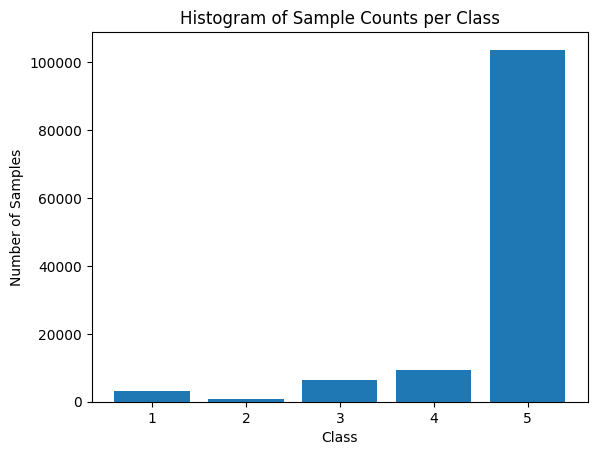

In [48]:
class_counts= read["Review"].value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Histogram of Sample Counts per Class')
plt.show()

In [50]:
model.save("Lstm/Model1")

INFO:tensorflow:Assets written to: Lstm/Model1\assets
